In [3]:
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = "cuda" if torch.cuda.is_available() else "cpu"

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch Version: 2.5.1
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU


In [ ]:
# ### Prepare training data ###
target_ticker = 'COST'
null_value = -99

context_data, target_data = {}, {}
time_intervals = ['1_day', '1_hr', '5_min', '1_min']
for i in time_intervals:
    context_data[i] = pd.read_csv(f'../data/{i}_context_data.csv')
    target_data[i] = pd.read_csv(f'../data/{i}_target_data.csv')

context_df = pd.concat(context_data.values(), axis=1).fillna(null_value)
target_df = pd.concat(target_data.values(), axis=1).fillna(null_value)

display(context_df.tail(10))

,Date,TLT_Close,TLT_High,TLT_Low,TLT_Open,TLT_Volume,TLT_EMA_12,TLT_EMA_26,TLT_MACD,TLT_Signal,...,VXZ_Open,VXZ_Volume,VXZ_EMA_12,VXZ_EMA_26,VXZ_MACD,VXZ_Signal,VXZ_BB_upper,VXZ_BB_lower,VXZ_OBV,VXZ_ATR
8130,2025-06-13,86.330002,86.879997,85.779999,86.730003,49374000.0,85.992129,86.049649,-0.057520,-0.293061,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8131,2025-06-16,85.459999,86.430000,85.459999,86.080002,36496600.0,85.910263,86.005971,-0.095708,-0.253590,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8132,2025-06-17,86.500000,86.660004,85.750000,86.000000,34521600.0,86.000992,86.042566,-0.041574,-0.211187,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8133,2025-06-18,86.650002,87.089996,86.349998,86.879997,38589000.0,86.100839,86.087561,0.013278,-0.166294,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8134,2025-06-20,86.489998,86.790001,85.949997,86.139999,26001900.0,86.160710,86.117371,0.043339,-0.124368,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8135,2025-06-23,86.769997,87.440002,86.769997,86.930000,36851800.0,86.254446,86.165714,0.088732,-0.081748,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8136,2025-06-24,87.400002,87.589996,86.430000,86.470001,32959100.0,86.430686,86.257143,0.173543,-0.030689,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8137,2025-06-25,87.510002,87.510002,86.800003,87.110001,26345300.0,86.596734,86.349947,0.246787,0.024806,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8138,2025-06-26,87.949997,87.949997,87.199997,87.589996,30426300.0,86.804929,86.468469,0.336459,0.087137,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
8139,2025-06-27,87.995003,88.160004,87.375000,87.565002,38393162.0,86.988017,86.581546,0.406471,0.151003,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [4]:
def hyperbolic_discounting_loss(preds, targets, confs, time_horizons = [1,3,5,10], beta=0.5):
    """
    Calculate loss with hyperbolic discounting and confidence weighting.
    Args:
        preds: Predicted prices (batch_size, 4)
        targets: True prices (batch_size, 4)
        confs: Predicted confidence values (batch_size, 4)
        beta: Hyperbolic discount factor
            - Higher beta means more discounting for longer time horizons i.e. more impulsive
            - Lower beta means less discounting, more patience
        time_horizons: List of time horizons in trading days

    """
    time_horizons = torch.tensor(time_horizons, device=preds.device)  # Trading days
    discount_weights = 1 / (1 + beta * time_horizons)
    mse_loss = (preds - targets).pow(2)
    weighted_loss = discount_weights * mse_loss / (confs + 1e-6)  # Confidence adjustment
    confidence_penalty = torch.log(confs + 1e-6).mean()  # Encourage confident predictions
    return weighted_loss.mean() + 0.01 * confidence_penalty  # Regularize confidence


In [5]:
# Step 1: Create Target Columns
def create_targets(df, target_column, horizons):
    """
    Generate shifted target columns for specified horizons.
    """
    for horizon, shift in horizons.items():
        df[f"Target_{horizon}"] = df[target_column].shift(-shift)
    
    df.dropna(inplace=True)  # Remove rows with NaN targets
    return df

# Step 2: Normalize Features
def normalize_features(train_df, val_df, test_df, exclude_columns):
    """
    Normalize input features using Min-Max scaling, excluding specified columns (e.g., targets, Date).
    Returns normalized train, val, test DataFrames and the scaler.
    """
    # Fit scaler only on training features
    train_features = train_df.drop(columns=exclude_columns)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_features)
    train_norm = pd.DataFrame(train_scaled, columns=train_features.columns, index=train_features.index)
    for col in exclude_columns:
        train_norm[col] = train_df[col]

    # Transform val and test features using the same scaler
    val_features = val_df.drop(columns=exclude_columns)
    val_scaled = scaler.transform(val_features)
    val_norm = pd.DataFrame(val_scaled, columns=val_features.columns, index=val_features.index)
    for col in exclude_columns:
        val_norm[col] = val_df[col]

    test_features = test_df.drop(columns=exclude_columns)
    test_scaled = scaler.transform(test_features)
    test_norm = pd.DataFrame(test_scaled, columns=test_features.columns, index=test_features.index)
    for col in exclude_columns:
        test_norm[col] = test_df[col]

    return train_norm, val_norm, test_norm, scaler

# Step 3: Create Sequences for Transformer Input
def create_sequences(data, target_columns, seq_length):
    """
    Create sequences for transformer input with specified sequence length.
    """
    X, y = [], []
    data_values = data.drop(columns=target_columns).values
    target_values = data[target_columns].values

    for i in range(len(data) - seq_length):
        X.append(data_values[i:i + seq_length])
        y.append(target_values[i + seq_length])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Step 4: Custom Dataset for PyTorch
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Full Data Preparation Pipeline
def prepare_data_pipeline(df, target_column, horizons, sequence_length=30, batch_size=32):
    """
    Prepare data for transformer input: normalize, create targets, and generate sequences.
    """
    # Create targets
    df = create_targets(df, target_column, horizons)

    # Normalize features
    exclude_columns = [f"Target_{horizon}" for horizon in horizons.keys()]
    exclude_columns.append('Date')

    # Split data into training, validation, and test sets
    train_size = 0.7
    val_size = (1-train_size) / 2

    # ensure no data leakage by trimming max horizon
    max_horizon = max(horizons.values())
    n = len(df)
    train_end = int(n * train_size) - max_horizon
    val_end = int(n * (train_size + val_size)) - max_horizon

    train_dates = df.index[:train_end] if df.index.name == 'Date' else df['Date'][:train_end]
    val_dates = df.index[train_end:val_end] if df.index.name == 'Date' else df['Date'][train_end:val_end]
    test_dates = df.index[val_end:] if df.index.name == 'Date' else df['Date'][val_end:]
    print("Train dates:", train_dates.iloc[0], "to", train_dates.iloc[-1])
    print("Validation dates:", val_dates.iloc[0], "to", val_dates.iloc[-1])
    print("Test dates:", test_dates.iloc[0], "to", test_dates.iloc[-1])

    df = df.drop(columns=['Date']) if 'Date' in df.columns else df  # Drop date column if exists
    
    # ensure no data leakage by trimming max horizon
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Create sequences
    target_columns = [col for col in exclude_columns if col != 'Date']
    train_df, val_df, test_df, scaler = normalize_features(train_df, val_df, test_df, target_columns)

    train_X, train_y = create_sequences(train_df, target_columns, sequence_length)
    val_X, val_y = create_sequences(val_df, target_columns, sequence_length)
    test_X, test_y = create_sequences(test_df, target_columns, sequence_length)

    # Create DataLoaders
    train_loader = DataLoader(StockDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(StockDataset(val_X, val_y), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StockDataset(test_X, test_y), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler

,Date,TLT_Close,TLT_High,TLT_Low,TLT_Open,TLT_Volume,TLT_EMA_12,TLT_EMA_26,TLT_MACD,TLT_Signal,...,VXZ_Open,VXZ_Volume,VXZ_EMA_12,VXZ_EMA_26,VXZ_MACD,VXZ_Signal,VXZ_BB_upper,VXZ_BB_lower,VXZ_OBV,VXZ_ATR
8135,2025-06-23,86.769997,87.440002,86.769997,86.930000,36851800.0,86.254446,86.165714,0.088732,-0.081748,...,60.389999,12400.0,59.744111,59.515545,0.228566,0.054955,60.922112,57.915489,-1546325.0,1.037285
8136,2025-06-24,87.400002,87.589996,86.430000,86.470001,32959100.0,86.430686,86.257143,0.173543,-0.030689,...,58.750000,15500.0,59.568094,59.447727,0.120367,0.068038,60.797915,57.858686,-1561825.0,1.105857
8137,2025-06-25,87.510002,87.510002,86.800003,87.110001,26345300.0,86.596734,86.349947,0.246787,0.024806,...,58.169998,5000.0,59.376079,59.364192,0.011888,0.056808,60.761929,57.924671,-1566825.0,1.098714
8138,2025-06-26,87.949997,87.949997,87.199997,87.589996,30426300.0,86.804929,86.468469,0.336459,0.087137,...,58.009998,10000.0,59.145913,59.254252,-0.108338,0.023778,60.842664,57.757936,-1576825.0,1.043000
8139,2025-06-27,87.995003,88.160004,87.375000,87.565002,38393162.0,86.988017,86.581546,0.406471,0.151003,...,57.900002,1967.0,58.938850,59.146529,-0.207680,-0.022513,60.917162,57.555438,-1578792.0,0.990143


In [ ]:
# ### Prepare training data ###
# target_ticker = 'COST'
# context_df = pd.read_csv('../data/context_data.csv')
# target_df = pd.read_csv('../data/target_data.csv')

# # filter target_df for columns containing target ticker
# target_df = target_df.filter(like=target_ticker)
# input_data = pd.concat([context_df, target_df], axis=1).dropna()

# # filter for dates between 2010-01-01 and 2019-12-31
# input_data['Date'] = pd.to_datetime(input_data['Date'])
# input_data = input_data[(input_data['Date'] >= '2010-01-01') & (input_data['Date'] <= '2019-12-31')]
# print('num days total:', input_data.shape[0])

# # Define horizons for target predictions (trading days)
# horizons = {"1_day": 1, "1_week": 5, "1_month": 21, "3_month": 63}
# horizons = {"1_day": 1, '3_days': 3, "1_week": 5, '2_weeks': 10}
# horizons = {"1_day": 1, '3_days': 3, "1_week": 5}

# target_column = target_ticker + '_Close'  
# sequence_length = 32 # 21 = 1 month, 252 = 1 year
# batch_size = 32
# train_loader, val_loader, test_loader, scaler = prepare_data_pipeline(input_data, target_column, horizons, sequence_length, batch_size)

# # Display the shapes of the datasets
# print(f"Train Loader: {len(train_loader.dataset)} samples")     
# print(f"Validation Loader: {len(val_loader.dataset)} samples")
# print(f"Test Loader: {len(test_loader.dataset)} samples")

num days total: 2497
Train dates: 2010-02-01 00:00:00 to 2016-12-23 00:00:00
Validation dates: 2016-12-27 00:00:00 to 2018-06-21 00:00:00
Test dates: 2018-06-22 00:00:00 to 2019-12-23 00:00:00
Train Loader: 1707 samples
Validation Loader: 342 samples
Test Loader: 347 samples


In [1]:
import sys
from pathlib import Path

# Add the src directory to sys.path if not already present
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
	sys.path.append(str(src_path))

from model_def import MultiResolutionTransformer

In [ ]:
# Model parameters
embed_dim = 128
num_heads = 8
num_layers = 4
epochs = 500
hyp_disc_factor = 0.1
# get input dimensions from first batch
batch_X, _ = next(iter(train_loader))
input_dim = batch_X.shape[-1]
print(f"Input dimension: {input_dim}")

model = StockPriceTransformer(
    input_dim=input_dim,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=len(horizons),  # 4 targets for 1 day, 1 week, 1 month, and 1 year
    dropout=0.2
).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# print(model)


Input dimension: 247


In [ ]:
train_loss_arr, val_loss_arr = [], []
best_val_loss = float('inf')  # To track the best validation loss
early_stop_threshold = 5  # Early stopping threshold
early_stop_counter = 0  # Counter for early stopping

# Define a path to save the best model
best_model_path = "best_stock_price_transformer.pth"

for epoch in range(epochs):
    model.train()
    train_loss = 0

    # Training batch loop
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        price_preds, conf_preds = model(X)
        loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_arr.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass for validation
            price_preds, conf_preds = model(X)
            loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)
            val_loss += loss.item()

    val_loss_arr.append(val_loss / len(val_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

    # Early stopping and best model saving logic
    current_val_loss = val_loss / len(val_loader)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0  # Reset counter
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        # print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"Early stop counter: {early_stop_counter}/{early_stop_threshold}")

    # Check if early stopping criteria met
    if early_stop_counter >= early_stop_threshold:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break



Epoch 1/500, Train Loss: 7454.3920, Val Loss: 19817.2812
Epoch 2/500, Train Loss: 6704.9312, Val Loss: 19410.1594
Epoch 3/500, Train Loss: 6521.8575, Val Loss: 19111.6498
Epoch 4/500, Train Loss: 6409.5541, Val Loss: 18836.5616
Epoch 5/500, Train Loss: 6268.5455, Val Loss: 18576.1650
Epoch 6/500, Train Loss: 6134.6210, Val Loss: 18327.1569
Epoch 7/500, Train Loss: 6009.6521, Val Loss: 18087.0787
Epoch 8/500, Train Loss: 5902.0468, Val Loss: 17854.3004
Epoch 9/500, Train Loss: 5757.0472, Val Loss: 17626.4161
Epoch 10/500, Train Loss: 5657.0801, Val Loss: 17403.3252
Epoch 11/500, Train Loss: 5539.2298, Val Loss: 17181.4741
Epoch 12/500, Train Loss: 5402.4017, Val Loss: 16961.3298
Epoch 13/500, Train Loss: 5302.4077, Val Loss: 16742.2271
Epoch 14/500, Train Loss: 5192.1203, Val Loss: 16524.3007
Epoch 15/500, Train Loss: 5103.3891, Val Loss: 16304.6502
Epoch 16/500, Train Loss: 4986.5020, Val Loss: 16083.5835
Epoch 17/500, Train Loss: 4863.8925, Val Loss: 15863.2237
Epoch 18/500, Train Los

In [ ]:

# After training, load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
print(f"Loaded the best model with Val Loss: {best_val_loss:.4f}")

# Test set evaluation
test_loss = 0
all_price_preds = []
all_conf_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass for test set
        price_preds, conf_preds = model(X)
        loss = hyperbolic_discounting_loss(price_preds, y, conf_preds, list(horizons.values()), hyp_disc_factor)
        test_loss += loss.item()

        # Collect predictions and targets
        all_price_preds.append(price_preds.cpu())
        all_targets.append(y.cpu())

# Combine all batches
all_price_preds = torch.cat(all_price_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Calculate and print metrics
test_loss = test_loss / len(test_loader)
mse = mean_squared_error(all_targets, all_price_preds)
mae = mean_absolute_error(all_targets, all_price_preds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Loaded the best model with Val Loss: 509.8456
Test Loss: 7345.0991
Mean Squared Error (MSE): 9282.8877
Mean Absolute Error (MAE): 91.6952


C:\Users\saris\AppData\Local\Temp\ipykernel_55084\460928957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


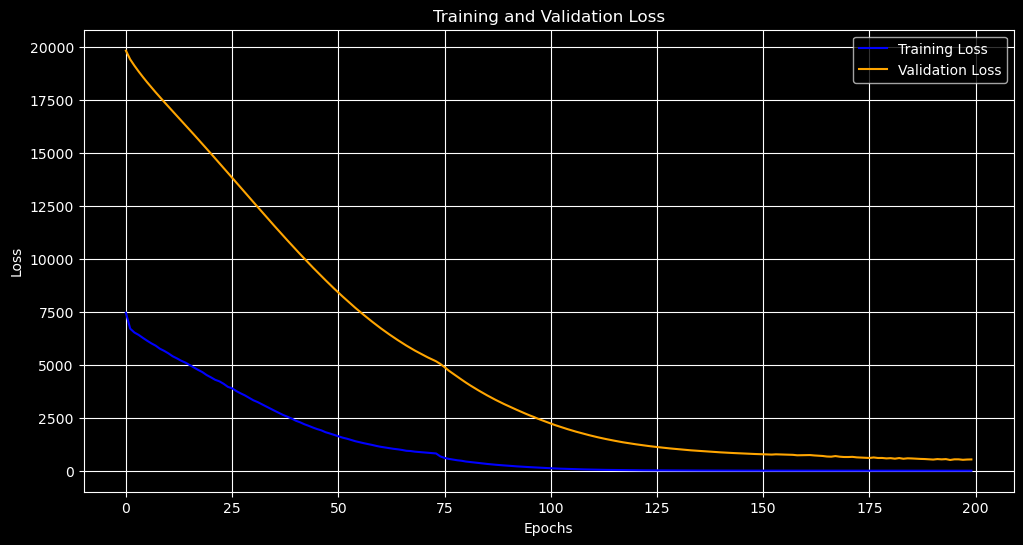

In [ ]:
# Plot tran val losses
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(train_loss_arr, label='Training Loss', color='blue')
plt.plot(val_loss_arr, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### Test set ###
all_price_preds = []
all_conf_preds = []

with torch.no_grad():
    for X, _ in test_loader:  # _ if targets included, ignore during inference
        X = X.to(device)
        price_preds, conf_preds = model(X)
        all_price_preds.append(price_preds.cpu())
        all_conf_preds.append(conf_preds.cpu())

# Concatenate all batches
all_price_preds = torch.cat(all_price_preds, dim=0).numpy()
all_conf_preds = torch.cat(all_conf_preds, dim=0).numpy()

print("Test Price Predictions shape:", all_price_preds.shape)
print("Test Confidence Predictions shape:", all_conf_preds.shape)

print(all_price_preds[:5])  # Display first 5 predictions
print(all_conf_preds[:5])  # Display first 5 confidence predictions
print('max conf:', np.max(all_conf_preds), 'max price:', np.max(all_price_preds))

Test Price Predictions shape: (347, 3)
Test Confidence Predictions shape: (347, 3)
[[138.13463 137.93793 138.06955]
 [138.13402 137.93732 138.06903]
 [138.13103 137.93416 138.0653 ]
 [138.1363  137.93965 138.0715 ]
 [138.13518 137.93826 138.0699 ]]
[[0.99999475 0.9999962  0.99999666]
 [0.99999475 0.9999962  0.99999666]
 [0.99999475 0.9999962  0.99999666]
 [0.99999475 0.9999962  0.99999666]
 [0.99999475 0.9999962  0.99999666]]
max conf: 0.9999968 max price: 138.18527
